<a href="https://colab.research.google.com/github/TurcsikZ/ZSPD-Deep-learning-projekt/blob/main/Data_discovering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ZSPD Project - Heart MRI superresolution </h1>

<h2> 1.Introduction </h2>

<p> In our project, the 4D images is used. The shape of these images is the following: (X,Y,Z_slices,T_time). We would like to use as image as possible, therefore first, we are focusing on the converting of images. Ater converting them, the low resolution images are made.</p>
<p> In this notebook, we will show the original images, how it looks like, what we can see in it. We will make the low resolution images, and cut the actual heart from the images. We want to cut the heart out because in the end we want the model to learn mainly the heart not the surrounding tissue. We will show, how we could create our new folder structure.</p>

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!wget "https://raw.githubusercontent.com/TurcsikZ/ZSPD-Deep-learning-projekt/main/data_preparation.py" 

--2022-10-23 17:03:20--  https://raw.githubusercontent.com/TurcsikZ/ZSPD-Deep-learning-projekt/main/data_preparation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7468 (7.3K) [text/plain]
Saving to: ‘data_preparation.py’

data_preparation.py 100%[===================>]   7.29K  --.-KB/s    in 0s      

2022-10-23 17:03:20 (68.3 MB/s) - ‘data_preparation.py’ saved [7468/7468]



In [3]:
!git clone "https://github.com/TurcsikZ/ZSPD-Deep-learning-projekt.git"

Cloning into 'ZSPD-Deep-learning-projekt'...
remote: Enumerating objects: 26369, done.
remote: Counting objects: 100% (1142/1142), done.
remote: Compressing objects: 100% (1103/1103), done.
remote: Total 26369 (delta 50), reused 1119 (delta 36), pack-reused 25227
Receiving objects: 100% (26369/26369), 1.93 GiB | 32.50 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (25958/25958), done.


In [4]:
from data_preparation import downsample2d, bbox, crop_img

In [5]:
data_path = '/content/ZSPD-Deep-learning-projekt/data/'

<h2> 2.Data discovering </h2>
<p> Using the following code to load the data. Our data is in nifti file, so we use the nibabel packages for it. In these images, we can see not just the heart, but all other human organs also.</p>

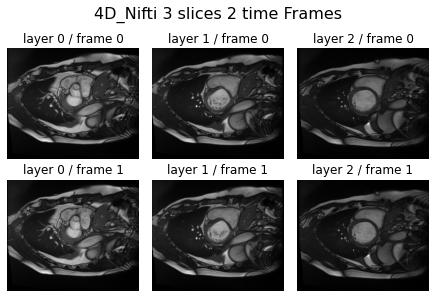

In [6]:
nii_img  = nib.load(os.path.join(data_path,'raw_data/patient001/','patient001_4d.nii.gz'))
nii_data = nii_img.get_fdata()

number_of_frames = 2
number_of_slices = 3

fig, ax = plt.subplots(number_of_frames, number_of_slices,constrained_layout=True)
fig.canvas.set_window_title('4D Nifti Image')
fig.suptitle('4D_Nifti 3 slices 2 time Frames', fontsize=16)
#-------------------------------------------------------------------------------
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

for slice in range(number_of_slices):
    for frame in range(number_of_frames):
        ax[frame, slice].imshow(nii_data[:,:,slice,frame],cmap='gray', interpolation=None)
        ax[frame, slice].set_title("layer {} / frame {}".format(slice, frame))
        ax[frame, slice].axis('off')

plt.show() 

<p> Shape of our data: </p>

In [7]:
nii_data.shape

(216, 256, 10, 30)

<p> Our data contains 2D slices images, but we will not use of them in our project. A little example of this kind of image: </p>

In [8]:
nii_img_frame  = nib.load(os.path.join(data_path,'raw_data/patient001/','patient001_frame01.nii.gz'))
nii_data_frame = nii_img_frame.get_fdata()
nii_data_frame.shape

(216, 256, 10)

<p> Our data contains the position of the heart, which will be used for the segmentation of the original images. </p>

In [9]:
nii_img_frame_gt  = nib.load(os.path.join(data_path,'raw_data/patient001/','patient001_frame01_gt.nii.gz'))
nii_data_frame_gt = nii_img_frame_gt.get_fdata()
nii_data_frame_gt.shape

(216, 256, 10)

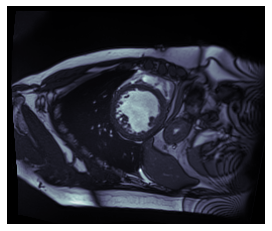

In [10]:
# The whole image
plt.imshow(nii_data_frame[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

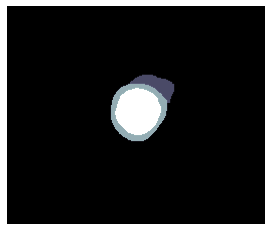

In [11]:
# The heart of the above image 
plt.imshow(nii_data_frame_gt[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

<h2> 3.Data preprocessing </h2>

<p> As we mentioned before, we would like to use all of the slices of the 4D images. To get 2D images from 4D, we loop over the Z and T dimensions. After that, we do the downsampling and segment the images.  </p> 
<p> In this notebook we show the above processes for one example, but in our <b> data_preparation.py </b>, the code is written for all patient folders.</p>

<h3> 3.1 Downsampling </h3>

In [12]:
# Original shape
nii_data[:,:,0,0].shape

(216, 256)

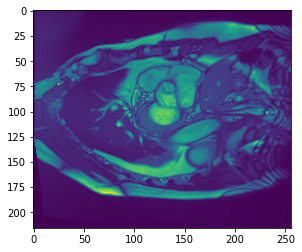

In [13]:
# Original image
plt.imshow(nii_data[:,:,0,0])

In [14]:
# New shape
downsample_img = downsample2d(nii_data[:,:,0,0],2)
downsample_img.shape

(108, 128)

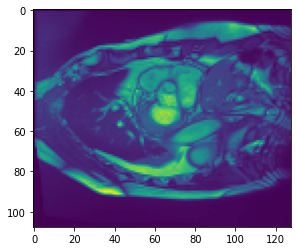

In [15]:
# New image
plt.imshow(downsample_img)

<h3> 3.2 Bounding box</h3>

In [16]:
nii_img_frame_1_gt  = nib.load(os.path.join(data_path,'raw_data/patient001/','patient001_frame01_gt.nii.gz'))
seg_frame_1 = nii_img_frame_1_gt.get_fdata()

nii_img_frame_2_gt  = nib.load(os.path.join(data_path,'raw_data/patient001/','patient001_frame12_gt.nii.gz'))
seg_frame_2 = nii_img_frame_2_gt.get_fdata()

In [17]:
bbox_boundaries = bbox(seg_frame_1, seg_frame_2)

In [18]:
croped_img = crop_img(nii_data[:,:,0,0], bbox_boundaries)

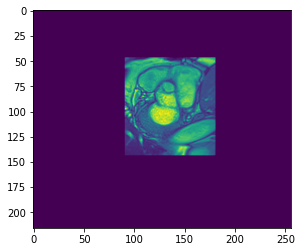

In [19]:
plt.imshow(croped_img)

<h3> 3.3 Saving data </h3>

<p> This session is not been necessary to run, because our repository has already contains these files. If you want to try our saving code, you can run this code below. </p>

In [20]:
from data_preparation import patient_train_split, data_transform_split

In [21]:
train, val, test = patient_train_split()

In [22]:
data_transform_split(data_path, train, "train")

Proccessing patient092 for the train set...
Proccessing patient050 for the train set...
Proccessing patient032 for the train set...
Proccessing patient046 for the train set...
Proccessing patient034 for the train set...
Proccessing patient008 for the train set...
Proccessing patient016 for the train set...
Proccessing patient022 for the train set...
Proccessing patient045 for the train set...
Proccessing patient062 for the train set...
Proccessing patient075 for the train set...
Proccessing patient049 for the train set...
Proccessing patient072 for the train set...
Proccessing patient024 for the train set...
Proccessing patient074 for the train set...
Proccessing patient047 for the train set...
Proccessing patient018 for the train set...
Proccessing patient055 for the train set...
Proccessing patient078 for the train set...
Proccessing patient076 for the train set...
Proccessing patient052 for the train set...
Proccessing patient002 for the train set...
Proccessing patient097 for the t

In [23]:
data_transform_split(data_path, val, "val")

Proccessing patient065 for the val set...
Proccessing patient066 for the val set...
Proccessing patient063 for the val set...
Proccessing patient089 for the val set...
Proccessing patient011 for the val set...
Proccessing patient044 for the val set...
Proccessing patient100 for the val set...
Proccessing patient081 for the val set...
Proccessing patient010 for the val set...
Proccessing patient051 for the val set...
Proccessing patient093 for the val set...
Proccessing patient021 for the val set...
Proccessing patient060 for the val set...
Proccessing patient012 for the val set...
Proccessing patient033 for the val set...
Proccessing patient095 for the val set...
Proccessing patient077 for the val set...
Proccessing patient053 for the val set...
Proccessing patient064 for the val set...
Proccessing patient098 for the val set...


Done in 36.45 seconds


In [24]:
data_transform_split(data_path, test, "test")

Proccessing patient014 for the test set...
Proccessing patient073 for the test set...
Proccessing patient091 for the test set...
Proccessing patient038 for the test set...
Proccessing patient042 for the test set...
Proccessing patient058 for the test set...
Proccessing patient059 for the test set...
Proccessing patient079 for the test set...
Proccessing patient030 for the test set...
Proccessing patient007 for the test set...


Done in 18.73 seconds
